In [1]:
import numpy as np
import time
from concurrent.futures import ProcessPoolExecutor
from dask.distributed import Client

In [2]:
def drop_check(num_points):
    
    '''This function draws num_points points from a uniform distribution over [0,1) x [0,1)
       and checks whether the points lie inside a quarter of a circle inscribed in the quadrant
       
       For points inside, points_in is incremented to keep count of the points inside the circle'''
    
    points_in = 0 #initialize points_in to 0
    
    for point in range(int(num_points)):
        x, y = np.random.uniform(), np.random.uniform() #draw x, y from a uniform distribution over [0,1)
        if pow(x, 2) + pow(y, 2) <= 1.0: #if a point is inside the circle, increment points_in
            points_in += 1
            
    return points_in

In [3]:
def MonteCarlo_Pi_Serial(num_points):
    
    '''This function calls drop_check in serial, clocks its execution time, 
       computes a point rate and approximates pi'''
    
    start = time.time() #start time of serial computation
    
    ### call function that drops points and checks if they are inside circle ###
    points_in = drop_check(num_points)
    
    end = time.time() #end time of serial computation
    
    total_time = end - start #difference of end and start gives total serial computation time
    point_rate = num_points / total_time #points dropped over total time gives serial point rate
    pi_approx = 4 * (points_in / num_points) #pi approximation 
    
    return pi_approx, total_time, point_rate

In [4]:
def MonteCarlo_Pi_Futures(num_points):
    
    '''This function calls drop_check in parallel using concurrent.futures, 
       clocks its execution time, computes a point rate and approximates pi'''
    
    executor = ProcessPoolExecutor(2) #set up a pool of 2 workers processes
    
    start = time.time() #start time of parallel computation
    
    ### execute map ###
    ### divide work in drop_check between two processes with half as many points to check ###
    ### sum the number of points inside circle for each processes for total points inside circle ###
    points_in = sum(list(executor.map(drop_check, [num_points / 2, num_points / 2])))
    
    end = time.time() #end time of parallel computation
    
    executor.shutdown() #close down pool of worker processes
    
    total_time = end - start #difference of end and start gives total parallel computation time
    point_rate = num_points / total_time #points dropped over total time gives parallel point rate
    pi_approx = 4 * (points_in / num_points) #pi approximation
    
    return pi_approx, total_time, point_rate

In [5]:
def MonteCarlo_Pi_Dask(num_points):
    
    '''This function calls drop_check in parallel using dask, 
       clocks its execution time, computes a point rate and approximates pi'''
    
    executor = Client(set_as_default=True) #set up local executor client
    
    start = time.time() #start time of parallel computation
    
    ### execute submit ###
    ### divide work in drop_check between two processes with half as many points to check ###
    ### sum the number of points inside circle for each processes for total points inside circle ###
    points_in = [executor.submit(drop_check, number) for number in [num_points / 2, num_points / 2]]
    points_in = sum([f.result() for f in points_in])
    
    end = time.time() #end time of parallel computation
    
    executor.close() #close down local executor client
    
    total_time = end - start #difference of end and start gives total parallel computation time
    point_rate = num_points / total_time #points dropped over total time gives parallel point rate
    pi_approx = 4 * (points_in / num_points) #pi approximation
    
    return pi_approx, total_time, point_rate

In [6]:
#range of number of points to drop, 10 - 10,000,000
point_range = [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]

In [7]:
#call serial function over point_range with map
results_serial = list(map(MonteCarlo_Pi_Serial, point_range))

In [8]:
#call concurrent futures function over point_range with map
results_futures = list(map(MonteCarlo_Pi_Futures, point_range))

In [9]:
#call dask function over point_range with map
results_dask = list(map(MonteCarlo_Pi_Dask, point_range))

In [10]:
#build lists containing execution times and point rates
#for the serial and parallel implementations

serial_times = []
futures_times = []
dask_times = []

serial_rates = []
futures_rates = []
dask_rates = []

for index in range(len(point_range)):
    serial_times.append(results_serial[index][1])
    futures_times.append(results_futures[index][1])
    dask_times.append(results_dask[index][1])
    
    serial_rates.append(results_serial[index][2])
    futures_rates.append(results_futures[index][2])
    dask_rates.append(results_dask[index][2])

<IPython.core.display.Javascript object>


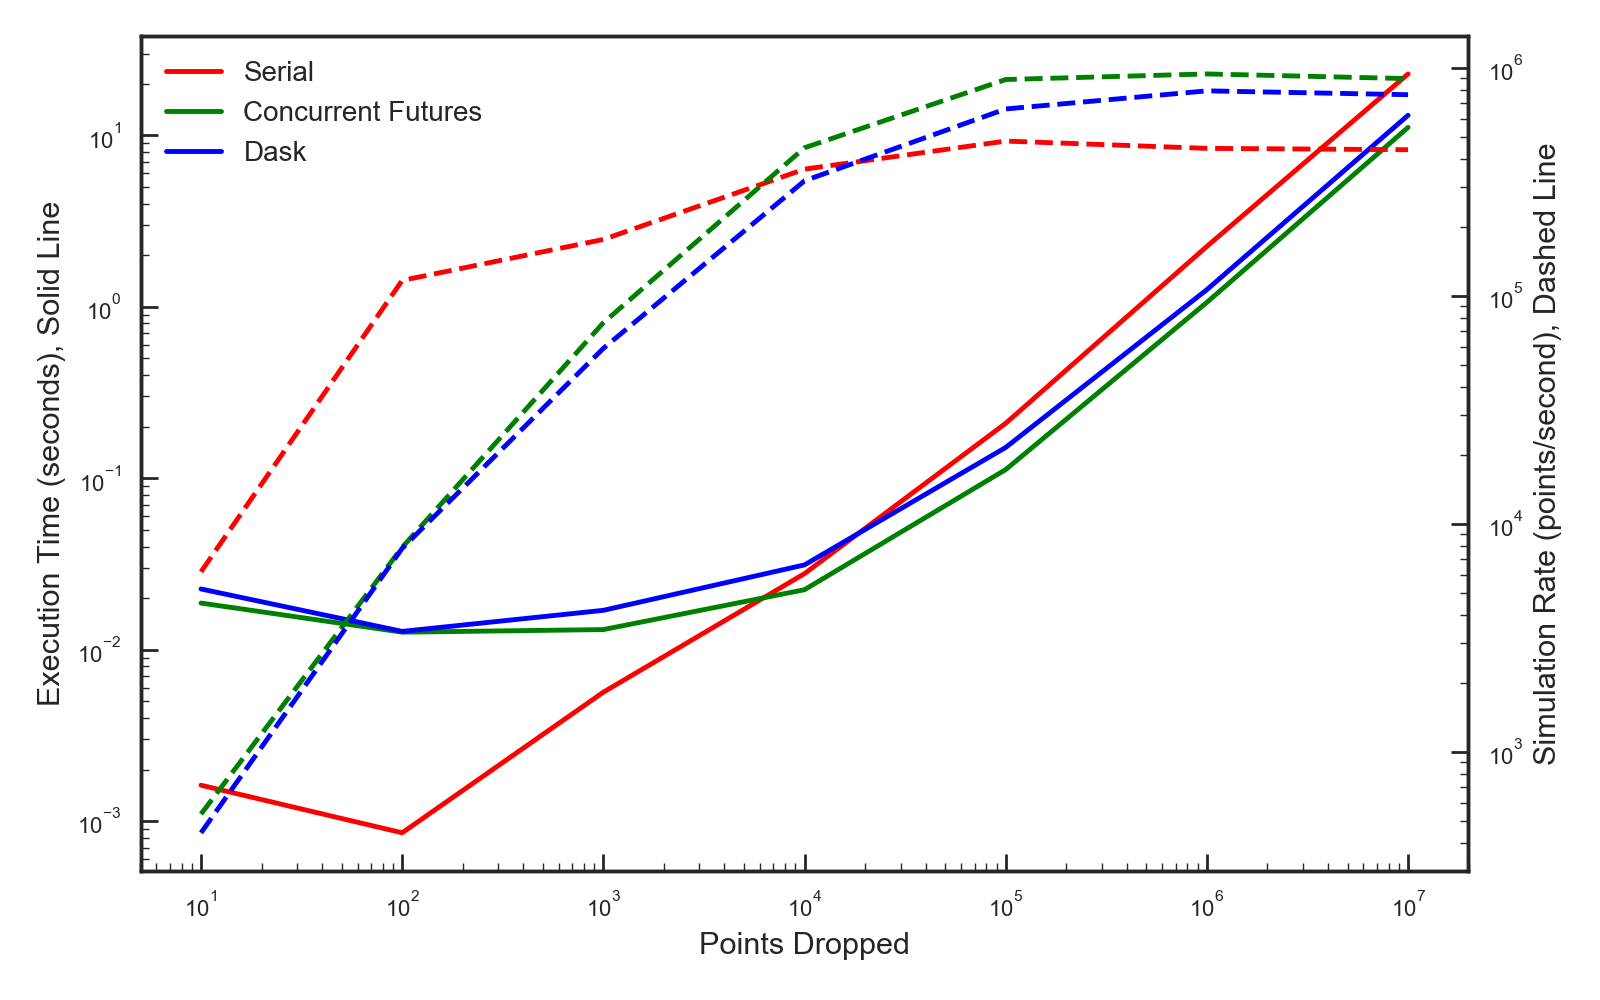

In [18]:
#compare the results of the monte carlo pi approximation 
#using serial and parallel implementations
#here we just compare a single run over the point range,
#no mean execution times of error bars in this fig (see later cells for means/errors)

import seaborn as sns

#use seaborn to make any plots look nice
sns.set_context("poster")
sns.set(style = "ticks")

import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax1 = plt.subplots(figsize = (8,5))

ax2 = ax1.twinx()

ax1.plot(point_range, serial_times, 'r-', label = 'Serial')
ax1.plot(point_range, futures_times, 'g-', label = 'Concurrent Futures')
ax1.plot(point_range, dask_times, 'b-', label = 'Dask')
ax1.set_xlabel('Points Dropped')
ax1.set_ylabel('Execution Time (seconds), Solid Line')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.minorticks_on()
ax1.tick_params(which = 'both', direction = 'in', labelsize = 8)
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels)

ax2.plot(point_range, serial_rates, 'r--')
ax2.plot(point_range, futures_rates, 'g--')
ax2.plot(point_range, dask_rates, 'b--')
ax2.set_yscale('log')
ax2.minorticks_on()
ax2.tick_params(which = 'both', direction = 'in', labelsize = 8)
ax2.set_ylabel('Simulation Rate (points/second), Dashed Line')
fig.tight_layout()
fig.show()
plt.savefig('/Users/danslaughter/Desktop/MacBook_2.6GHz_i5_single_run.pdf')

In [12]:
#build lists containing mean execution times, mean point rates
#and errors for the serial implementations run 10 times in a row

serial_runs = []

for _ in range(10):
    results_serial = list(map(MonteCarlo_Pi_Serial, point_range))
    serial_runs.append(results_serial)

exec_times_serial = []
point_rate_serial = []

for index1 in range(7):
    for index2 in range(len(serial_runs)):
        exec_times_serial.append(serial_runs[index2][index1][1])
        point_rate_serial.append(serial_runs[index2][index1][2])

mean_exec_times_serial = []
mean_point_rate_serial = []
std_exec_times_serial = []

for index in range(int(len(exec_times_serial) / 10)):
    mean_exec_times_serial.append(np.mean(exec_times_serial[10 * index: 10 * (index + 1)]))
    mean_point_rate_serial.append(np.mean(point_rate_serial[10 * index: 10 * (index + 1)]))
    std_exec_times_serial.append(np.std(exec_times_serial[10 * index: 10 * (index + 1)]))

In [13]:
#build lists containing mean execution times, mean point rates
#and errors for the concurrent.futures implementations run 10 times in a row

futures_runs = []

for _ in range(10):
    results_futures = list(map(MonteCarlo_Pi_Futures, point_range))
    futures_runs.append(results_futures)

exec_times_futures = []
point_rate_futures = []

for index1 in range(7):
    for index2 in range(len(futures_runs)):
        exec_times_futures.append(futures_runs[index2][index1][1])
        point_rate_futures.append(futures_runs[index2][index1][2])

mean_exec_times_futures = []
mean_point_rate_futures = []
std_exec_times_futures = []

for index in range(int(len(exec_times_futures) / 10)):
    mean_exec_times_futures.append(np.mean(exec_times_futures[10 * index: 10 * (index + 1)]))
    mean_point_rate_futures.append(np.mean(point_rate_futures[10 * index: 10 * (index + 1)]))
    std_exec_times_futures.append(np.std(exec_times_futures[10 * index: 10 * (index + 1)]))

In [14]:
#build lists containing mean execution times, mean point rates
#and errors for the dask implementations run 10 times in a row

dask_runs = []

for _ in range(10):
    results_dask = list(map(MonteCarlo_Pi_Dask, point_range))
    dask_runs.append(results_dask)
    
exec_times_dask = []
point_rate_dask = []

for index1 in range(7):
    for index2 in range(len(dask_runs)):
        exec_times_dask.append(dask_runs[index2][index1][1])
        point_rate_dask.append(dask_runs[index2][index1][2])

mean_exec_times_dask = []
mean_point_rate_dask = []
std_exec_times_dask = []

for index in range(int(len(exec_times_dask) / 10)):
    mean_exec_times_dask.append(np.mean(exec_times_dask[10 * index: 10 * (index + 1)]))
    mean_point_rate_dask.append(np.mean(point_rate_dask[10 * index: 10 * (index + 1)]))
    std_exec_times_dask.append(np.std(exec_times_dask[10 * index: 10 * (index + 1)]))

<IPython.core.display.Javascript object>


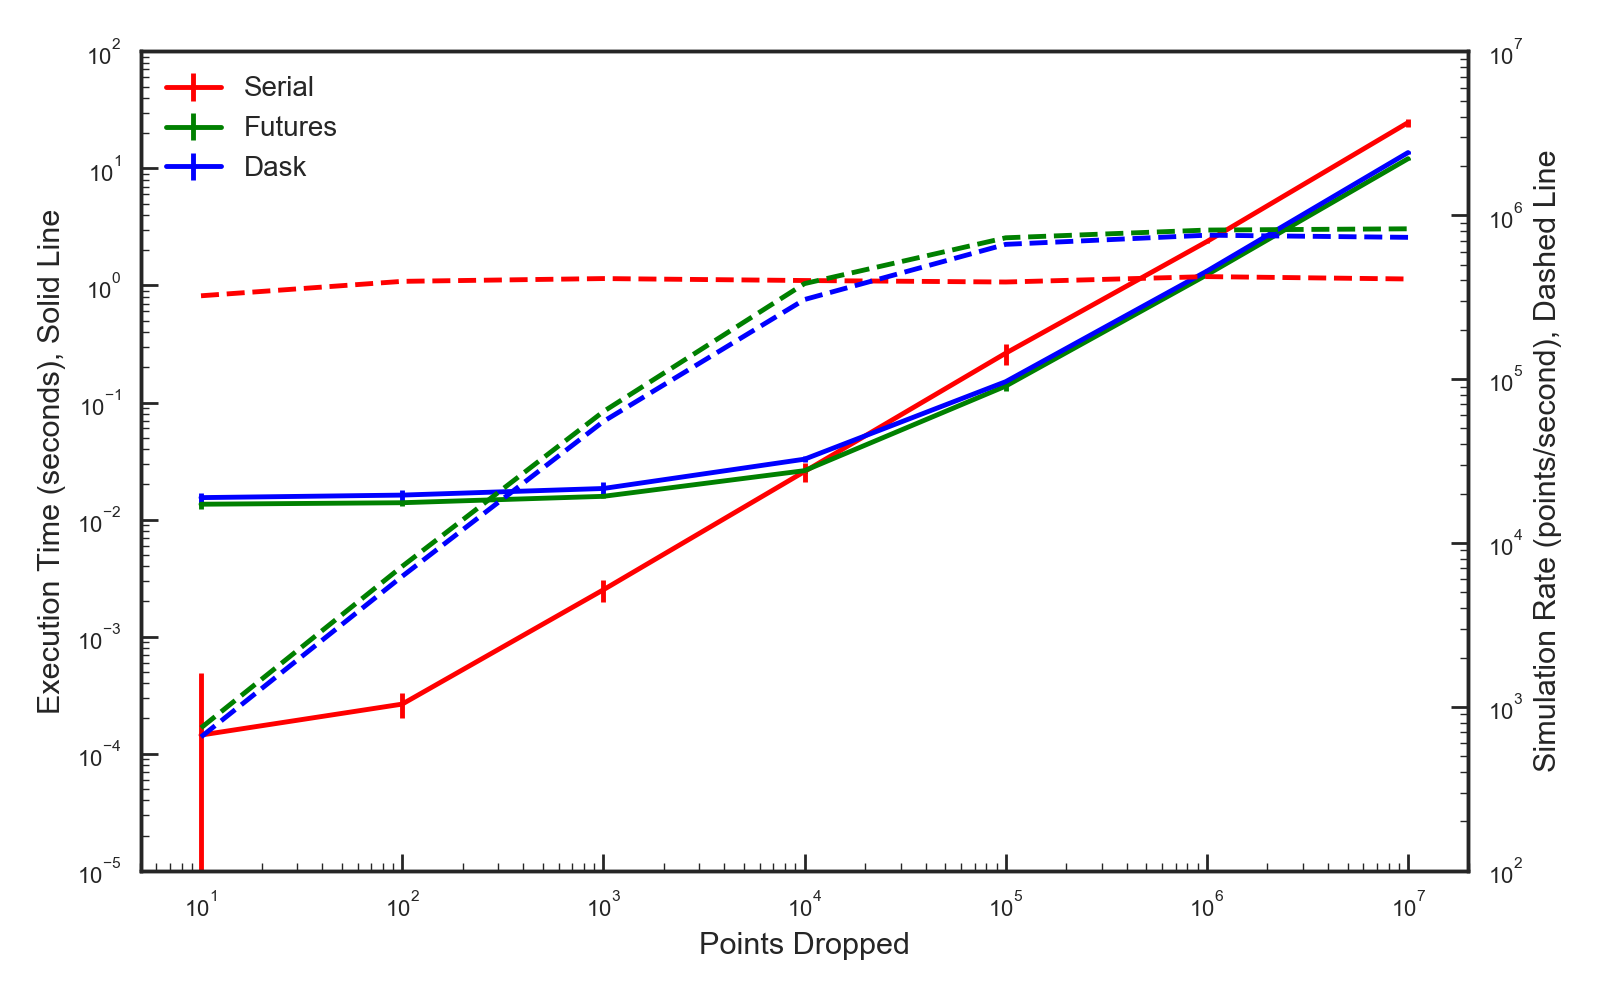

In [19]:
#compare the results of the monte carlo pi approximation 
#using serial and parallel implementations
#here we compare values from 10 different executions over the point range,
#shown are mean execution times with associated error bars

fig_mean, ax1_mean = plt.subplots(figsize = (8,5))

ax2_mean = ax1_mean.twinx()

ax1_mean.errorbar(point_range, mean_exec_times_serial, std_exec_times_serial, color = 'r', ecolor = 'r', label = 'Serial')
ax1_mean.errorbar(point_range, mean_exec_times_futures, std_exec_times_futures, color = 'g', ecolor = 'g', label = 'Futures')
ax1_mean.errorbar(point_range, mean_exec_times_dask, std_exec_times_dask, color = 'b', ecolor = 'b', label = 'Dask')
ax1_mean.set_xlabel('Points Dropped')
ax1_mean.set_ylabel('Execution Time (seconds), Solid Line')
ax1_mean.set_ylim(1e-5, 1e2)
ax1_mean.set_yscale('log')
ax1_mean.set_xscale('log')
ax1_mean.minorticks_on()
ax1_mean.tick_params(which = 'both', direction = 'in', labelsize = 8)
lines, labels = ax1_mean.get_legend_handles_labels()
ax1_mean.legend(lines, labels)

ax2_mean.plot(point_range, mean_point_rate_serial, 'r--')
ax2_mean.plot(point_range, mean_point_rate_futures, 'g--')
ax2_mean.plot(point_range, mean_point_rate_dask, 'b--')
ax2_mean.set_ylim(1e2, 1e7)
ax2_mean.set_yscale('log')
ax2_mean.minorticks_on()
ax2_mean.tick_params(which = 'both', direction = 'in', labelsize = 8)
ax2_mean.set_ylabel('Simulation Rate (points/second), Dashed Line')

fig_mean.tight_layout()
fig_mean.show()
plt.savefig('/Users/danslaughter/Desktop/MacBook_2.6GHz_i5_10_runs.pdf')